# TomoTwin: A simple digital twin for synchrotron micro-CT

### Author: Aniket Tekawade  

1. Phantom with Fuel Injector Nozzle (Label 0 is void, label 1 is steel)  
2. model attenuation / noise with Poisson assumption and data from XOP  
3. ignore phase-contrast effects 
4. model beam profile with XOP data on bending magnet power distribution at 35 m from source

Important Information: Data from this notebook has not been published yet. Please contact the author if you intend on using it.

In [1]:
%matplotlib inline
# pip package imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ct_segnet.data_utils.data_io import DataFile
from ct_segnet import viewer
import time

# local imports
if "../tomo_twin" not in sys.path: # local imports
    sys.path.append('../tomo_twin')
import ray_utils as ray
from utils import *
source_file_path = '../model_data/source_files/7BM/beam_profile_7BM.hdf5'

# import ipywidgets.interact class, this class will represent a slide bar.
from ipywidgets import interact
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout
from IPython.display import display
figw = 12

In [2]:
energy_pts = 50.0 # can also input a discrete list of energies, e.g. np.asarray([7,14,28]), etc.
detector_dist = 15.0 #50.0 # cm
nprojs = 2000
exp_fac = 0.92
sample_tag = "fuelinj_%ikeV_%icm_%iprojs"%(energy_pts, detector_dist, nprojs)
print(sample_tag)

fuelinj_50keV_15cm_2000projs


## Make 'beam' or 'flat-field' array  
Intensity profile of a bending magnet beam at APS. Data is taken from XOP and is in the "model_data/source_files" folder. In brief, the data is a power field at a 35 meter distance from the BM source. First, pre-select the FOV and pixel resolution, then pass the shape of the resulting FOV to request a cropped-out flat-field array for this FOV. It is assumed that the camera is well-centered on the vertical center ofthe fan beam.  

**Comments:** The power also varies with beam energy and monochromatic beam of a given energy is assumed here. With this code, polychromatic beam can also be calculated by passing a discrete list of energies. The output for each energy will be in a separate channel of the data. Use simpspons rule to integrate all energies for a white beam.  

### Select the FOV  

In [3]:
skip_fac = 2
FOV = (100,1920//skip_fac) # Vertical, Horizontal in nrows, ncols
res = 1.17*skip_fac
n_projections = nprojs//skip_fac+1
print("FOV of %.1f mm high, %.1f mm wide; pixel size %.2f um"%(FOV[0]*res/1000, FOV[1]*res/1000, res))
proj_shape = FOV
obj_shape = (proj_shape[0], proj_shape[1], proj_shape[1])
print("Shape of the projection image: %s"%str(proj_shape))

FOV of 0.2 mm high, 2.2 mm wide; pixel size 2.34 um
Shape of the projection image: (100, 960)


### Select the acquisition parameters: (beam energy, noise and number of projections)  

In [4]:
theta = (0,180,n_projections)
noise = 1.0 # the noise std. dev. based on the Poisson model is increased by that factor.  
blur_size = 3

In [5]:
beam = ray.read_source(source_file_path, \
                       energy_pts, \
                       res = res, \
                       img_shape = proj_shape, \
                       exp_fac = exp_fac)
# beam = (2**16-1)*np.ones(proj_shape, dtype = np.float32)[np.newaxis,...]

In [6]:
print("beam array shape is n_energies, nz, nx: %s"%str(beam.shape))

beam array shape is n_energies, nz, nx: (1, 100, 960)


intensity range in projection image: 5082 to 63535


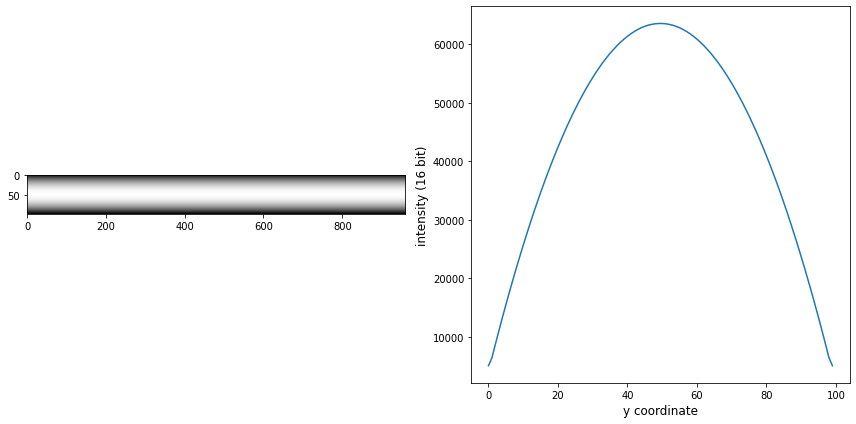

In [7]:
print("intensity range in projection image: %i to %i"%(beam.min(), beam.max()))
fig, ax = plt.subplots(1,2, figsize = (figw,figw/2))
h = ax[0].imshow(beam[0], cmap = 'gray')
h = ax[1].plot(beam[0,:,beam.shape[-1]//2])
h = ax[1].set_xlabel("y coordinate", fontsize = 12)
h = ax[1].set_ylabel("intensity (16 bit)", fontsize = 12)
fig.tight_layout()

## Read the Ground-Truth Phantom

 Read the phantom and check for inconsistencies, set bounds, downsize and crop.  

In [8]:
fpath = '../data/fuelinjector/Recon_Aramco_GDI_SEG'
from ct_segnet.data_utils.data_io import DataFile

In [9]:
ds = DataFile(fpath, tiff = True, VERBOSITY = 0)
vol = ds.read_full()
vol = vol[600:800:skip_fac,::skip_fac,::skip_fac]

In [10]:
mat_dict = {"air" : 0.00122, "Fe" : 8.0}

In [11]:
Ph = ray.Phantom(vol, mat_dict, res, energy_pts)

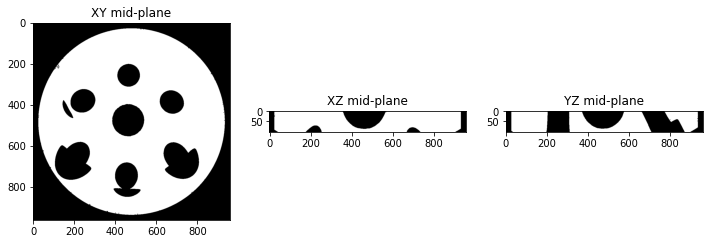

In [12]:
fig, ax = plt.subplots(1,3, figsize = (figw,figw/3))
h = viewer.view_midplanes(vol = Ph.vol, ax = ax)

## Synthetize Projections  

In [13]:
t0 = time.time()
projs = Ph.get_projections(theta = theta, beam = beam, \
                           noise = noise, \
                           detector_dist = detector_dist, \
                           blur_size = blur_size)
tot_time = (time.time() - t0)/60.0
print("Shape of the synthesized projections data: %s"%str(projs.shape))
print("Done in %.2f minutes"%tot_time)

Shape of the synthesized projections data: (1001, 100, 960)
Done in 1.51 minutes


### View Projections  

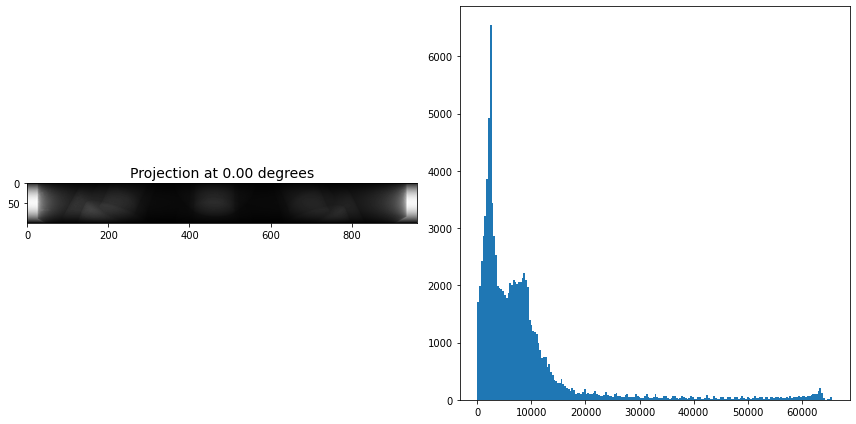

In [14]:
fig, ax = plt.subplots(1,2, figsize = (figw,figw/2))
h = ax[0].imshow(projs[0], cmap = 'gray')
h = ax[0].set_title("Projection at %.2f degrees"%theta[0], fontsize = 14)
h = ax[1].hist(projs[0].reshape(-1), bins = 200)
# h = ax[1].imshow(projs[-1], cmap = 'gray')
# h = ax[1].set_title("Projection at %.2f degrees"%theta[1], fontsize = 14)
fig.tight_layout()

### View Sinograms  

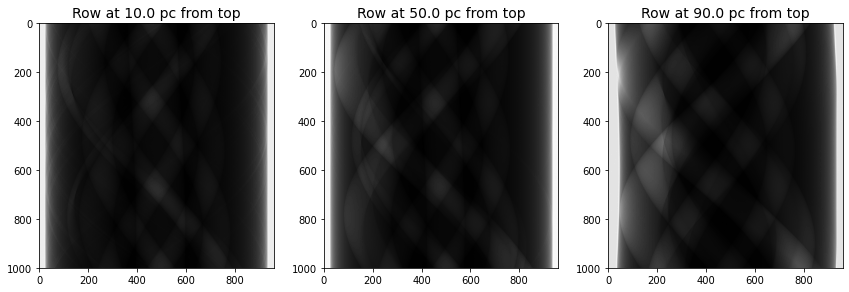

In [15]:
select_rows = [0.1,0.5,0.9]
select_idx = [int(select_row*projs.shape[1]) for select_row in select_rows]
fig, ax = plt.subplots(1,len(select_rows), figsize = (figw,figw/len(select_rows)))
for ii, idx in enumerate(select_idx):
    ax[ii].imshow(projs[:,idx,:], cmap = 'gray')
    ax[ii].set_title("Row at %.1f pc from top"%(100.0*select_rows[ii]), fontsize = 14)
fig.tight_layout()

## Do a test reconstruction with gridrec  

In [16]:
mask_ratio = 0.95
contrast_s = 0.01
pad_frac = 0.3
rec = recon_wrapper(projs, beam, theta, pad_frac = pad_frac, mask_ratio = mask_ratio, contrast_s = contrast_s)

Reconstructing 48 slice groups with 48 master threads...


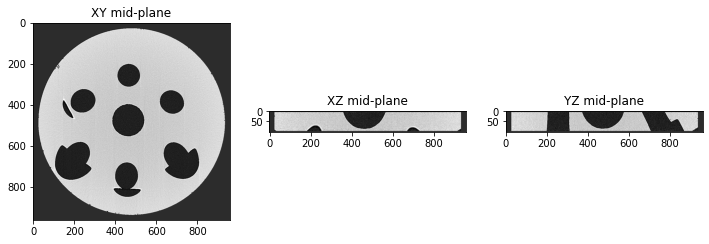

In [17]:
fig, ax = plt.subplots(1,3, figsize = (figw, figw/3))
h = viewer.view_midplanes(rec, ax = ax)

Text(0.5, 1.0, 'SNR = 10.11')

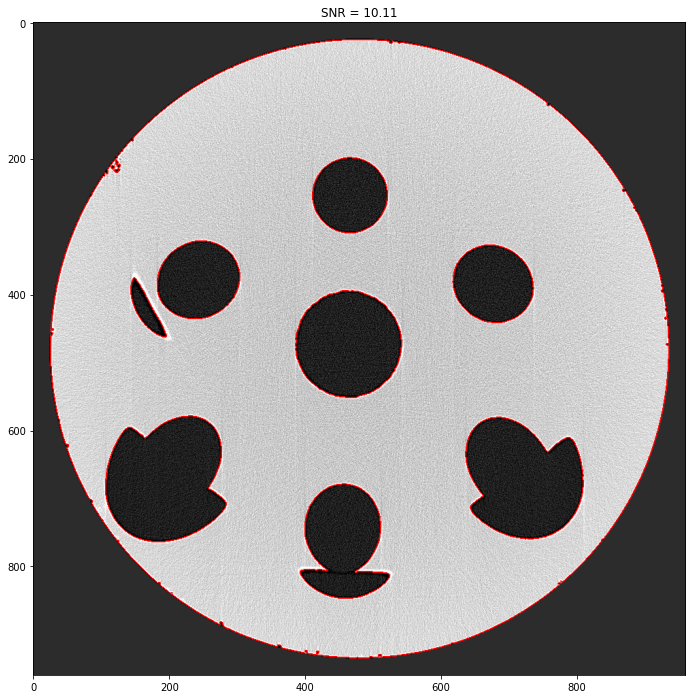

In [18]:
fig, ax = plt.subplots(1,1, figsize = (figw, figw))
idx_mid = int(rec.shape[0]//2)
viewer.edge_plot(rec[idx_mid], vol[idx_mid], ax = ax, color = [255,0,0])
ax.set_title("SNR = %.2f"%calc_SNR(rec[idx_mid], vol[idx_mid], labels = (0,1), mask_ratio = mask_ratio))

In [19]:
SNR_voids = calc_SNR(rec, vol, labels = (0,1), mask_ratio = mask_ratio)
print("SNR of material against voids: %.2f"%SNR_voids)

SNR of material against voids: 8.84


**Comments:** In this example, that there are two signal-noise ratios (SNR) to be evaluated: the contrast between the material and voids in background and the contrast between the inclusions against the material background. Depending on the attenuation properties of the materials, these may be very different.  

## Save Data Pairs  

We will save the following:  
1. Ground-truth labeled phantom (nz, ny, nx): Label 0 is void, label 1 is material, label 2 is inclusion material.  
2. Projection data: 16 bit data (n_projections, nrows, ncolumns).  
Note that ny = nx = ncolumns and nrows = nz.  
3. Test reconstruction: float (nz, ny, nx)

In [20]:
import json
import os

In [21]:
fname = "%s.hdf5"%sample_tag
fpath = os.path.join("/data02/MyArchive/TomoTwin/data", fname)
hf = h5py.File(fpath, 'w')

In [22]:
# save exchange/data, exchange/data_bright and data_dark
g = hf.create_group("exchange")
d = g.create_dataset("data", data = projs, dtype = np.uint16)
d = g.create_dataset("data_bright", data = beam, dtype = np.uint16)
d = g.create_dataset("data_dark", data = np.zeros_like(beam), dtype = np.uint16)

In [23]:
# save exchange/measurement
gm = g.create_group("measurement")
gm.attrs["pixel_size"] = res
gm.attrs["energy"] = energy_pts
gm.attrs["detector_dist"] = detector_dist
gm.attrs["n_projections"] = n_projections
gm.attrs["noise_level"] = noise
gm.attrs["blur_kernel"] = blur_size

In [24]:
crop_slice, vcrop_slice = get_cropslices(vol.shape, mask_ratio)

# save phantom
g = hf.create_group("tomo")
d = g.create_dataset("gt_labels", \
                     data = vol[vcrop_slice, crop_slice, crop_slice], \
                     dtype = np.float32)
d = g.create_dataset("recon", \
                     data = rec[vcrop_slice, crop_slice, crop_slice], \
                     dtype = np.float32)
gm = g.create_group("phantom")
gm.attrs["sample_tag"] = sample_tag
m = gm.create_dataset("mat_dict", data = json.dumps(mat_dict))
# m = gm.create_dataset("phantom_params", data = json.dumps(phantom_params))

In [25]:
hf.close()

In [26]:
time.ctime()

'Wed Feb  3 22:10:31 2021'